## **3D Semantic Segmentation of MRI scans**

In [1]:
# Libraries
import os
import numpy as np
import nibabel as nib ## Uncomment for preprocessing
import glob
import random
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
# Define the scaler function (MinMax)
scaler = MinMaxScaler()

In [3]:
# Set base path for training data
base_path = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
base_path_test = "BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

# Open the all the channels for a traning image (flair channel)
test_image_flair = nib.load(base_path + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
test_image_t1=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1ce=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t2=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_mask=nib.load(base_path + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
# As we can see the image is a 3D image with 240x240x155
print(f"Dimensions of the (flair) image: {test_image_flair.shape}")
print(f"Max value in the (flair) array: {test_image_flair.max()}")

Dimensions of the (flair) image: (240, 240, 155)
Max value in the (flair) array: 1854.603271484375


### **Preprocessing**

In [4]:
# Applying the scaler to 1D and then reshape back into 3D
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# Check the values in the mask file
test_mask=test_mask.astype(np.uint8)
print(np.unique(test_mask))

[0 1 2 4]


In [5]:
# Since the third class isnt defined, make class 4 into class 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

[0 1 2 3]


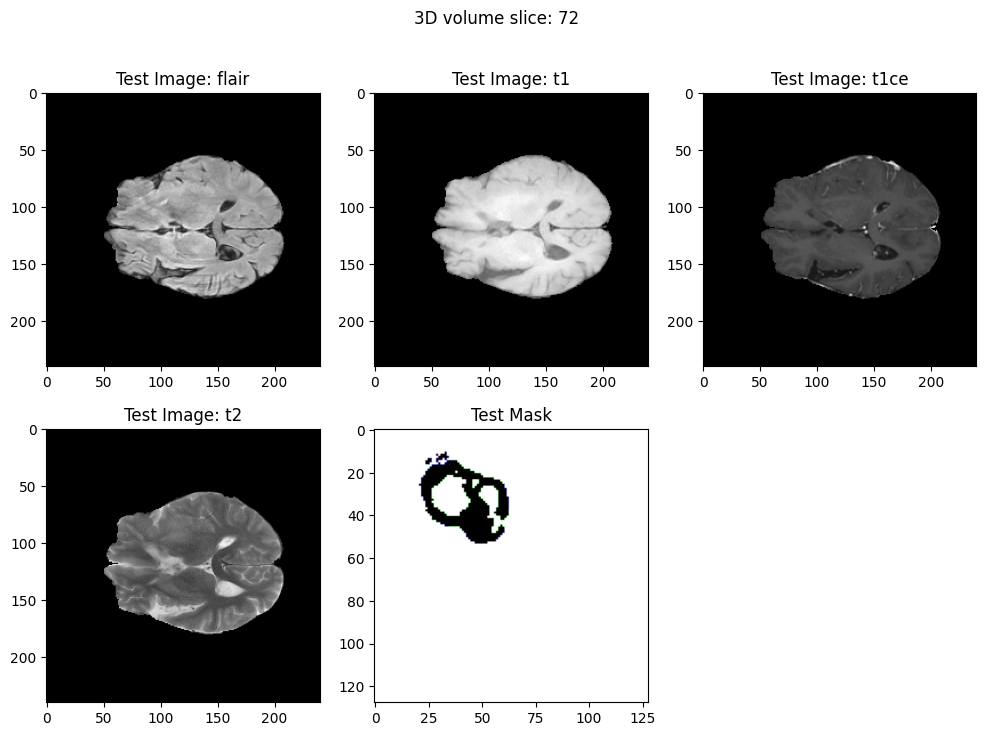

In [158]:
# Since the data is 3D we can only look at slices of the image (155) slices as a 2D image.

# Select a random slice

n_slice = random.randint(0, test_mask.shape[2])

# Print the images
plt.figure(figsize = (12,8))
plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Test Image: flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Test Image: t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Test Image: t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Test Image: t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Test Mask')
plt.suptitle(f"3D volume slice: {n_slice}")
plt.show()

In [9]:
# Since t1ce is a transformation of t1, we can drop the t1 (as it only contains less information)

# Therefore we combine the flair, t1ce and t2 channels into a single array
combined_volume = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis = 3)
combined_volume.shape

(240, 240, 155, 3)

In [11]:
# Crop the image to 128x128x128x4 centered around the main information 
# the sides of the images doesnt contain any information and can be dropped. 
# The size has to be a multiple of 16

combined_volume = combined_volume[56:184, 56:184, 13:141]
test_mask = test_mask[56:184, 56:184, 13:141]

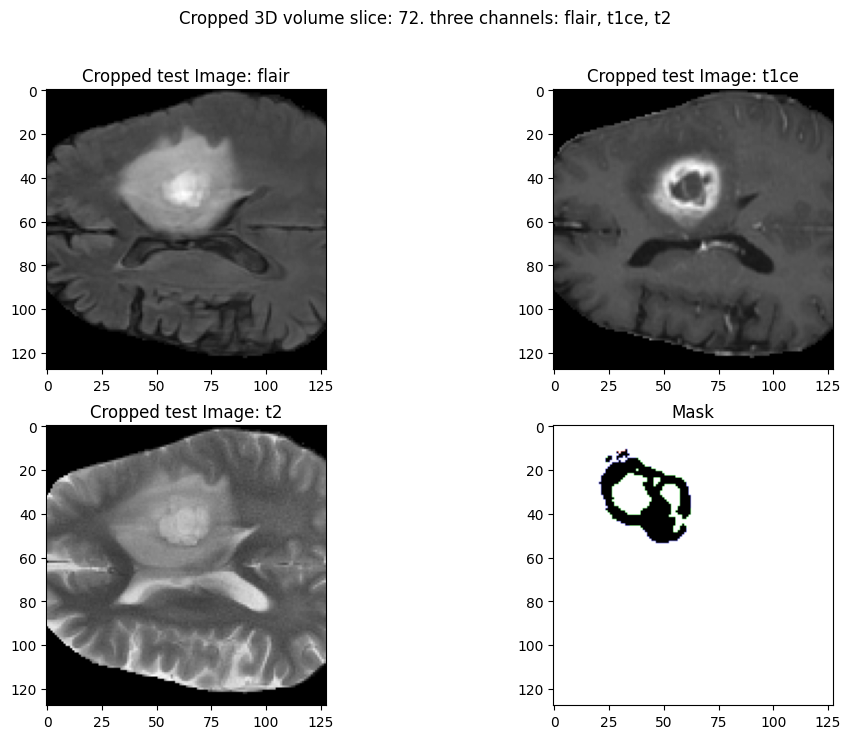

In [159]:
# Print the cropped images

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(combined_volume[:,:,n_slice, 0], cmap='gray')
plt.title('Cropped test Image: flair')
plt.subplot(222)
plt.imshow(combined_volume[:,:,n_slice, 1], cmap='gray')
plt.title('Cropped test Image: t1ce')
plt.subplot(223)
plt.imshow(combined_volume[:,:,n_slice, 2], cmap='gray')
plt.title('Cropped test Image: t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.suptitle(f"Cropped 3D volume slice: {n_slice}. three channels: flair, t1ce, t2")
plt.show()

In [13]:
# Save the images as a numpy array and see if we can read it properly
np.save("BraTS2020_TrainingData/combined255.npy", combined_volume)
my_img = np.load("BraTS2020_TrainingData/combined255.npy")
print(f"Saved array has dimensions: {my_img.shape}")
print(f"Saved array and and processed array are equal: {np.array_equal(my_img, combined_volume)}")

Saved array has dimensions: (128, 128, 128, 3)
Saved array and and processed array are equal: True


In [14]:
# Make categorical mask
test_mask = to_categorical(test_mask, num_classes = 4)

In [15]:
t2_list = sorted(glob.glob(base_path + "*/*t2.nii"))
t1ce_list = sorted(glob.glob(base_path + "*/*t1ce.nii"))
flair_list = sorted(glob.glob(base_path + "*/*flair.nii"))
mask_list = sorted(glob.glob(base_path + "*/*seg.nii"))

# Test data doesn't have any masks
t2_list_test = sorted(glob.glob(base_path_test + "*/*t2.nii"))
t1ce_list_test = sorted(glob.glob(base_path_test + "*/*t1ce.nii"))
flair_list_test = sorted(glob.glob(base_path_test + "*/*flair.nii"))
#mask_list_val = sorted(glob.glob(base_path_val + "*/*seg.nii"))

print(f"The training lists have equal length: {len(t2_list) == len(t1ce_list) == len(flair_list) == len(mask_list)}, length is {len(t2_list)}")
print(f"The test lists have equal length: {len(t2_list_test) == len(t1ce_list_test) == len(flair_list_test)}, length is {len(t2_list_test)}")

The training lists have equal length: True, length is 369
The test lists have equal length: True, length is 125


In [16]:
# Lets create the folders we need

top_directory = "data_dir/"
os.mkdir(top_directory)

directory = "input_data_3channels"

path = os.path.join(top_directory, directory)
os.mkdir(path)

directory_train = top_directory + directory + "/"
directory_img = "images"
train_img_path = os.path.join(directory_train, directory_img)
os.mkdir(train_img_path)

directory_mask = "masks"
train_mask_path = os.path.join(directory_train, directory_mask)
os.mkdir(train_mask_path)

test_directory = "test/"
path = os.path.join(top_directory, test_directory)
os.mkdir(path)

test_img_path = os.path.join(top_directory, test_directory+directory_img)
os.mkdir(test_img_path)

In [17]:
# Load, MinMax scale, combine and crop all training images then save
for img in range(len(t2_list)):
    #print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        #print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(train_img_path + '/image_' +str(img) + '.npy', temp_combined_images)
        np.save(train_mask_path + '/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("Image with less than 0.01 % of relevant information")   
    

Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with less than 0.01 % of relevant information
Image with l

In [18]:
# Load, MinMax scale, combine and crop all test images (which we will use for testing) then save
for img in range(len(t2_list_test)):
    #print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list_test[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list_test[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list_test[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
       
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]

    np.save(test_img_path + '/testimage_' + str(img) + '.npy', temp_combined_images)

In [20]:
#pip install split-folders


In [21]:
import splitfolders
input_folder = 'data_dir/input_data_3channels/'
output_folder = 'data_dir/trainval/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 688 files [00:37, 18.38 files/s]


In [ ]:
# Optional: Delete some of the unpreprocessed data to clean up space





### **Using the custom data generator**

In [22]:
# Import the custom script
import custom_datagenerator as datagen

In [23]:
# define our data paths
train_img_path = "data_dir/trainval/train/images"
train_mask_path = "data_dir/trainval/train/masks"

val_img_path = "data_dir/trainval/val/images"
val_mask_path = "data_dir/trainval/val/masks"

print(train_img_path)
print(train_mask_path)
print(val_img_path)
print(val_mask_path)

data_dir/trainval/train/images
data_dir/trainval/train/masks
data_dir/trainval/val/images
data_dir/trainval/val/masks


In [24]:
# Get a list of the images and masks
train_img_list = sorted(os.listdir(train_img_path))
train_mask_list = sorted(os.listdir(train_mask_path))

val_img_list = sorted(os.listdir(val_img_path))
val_mask_list = sorted(os.listdir(val_mask_path))

In [25]:
# Check if the sorting made them match up
print(train_img_list[0:5])
print(train_mask_list[0:5])

num_images = len(os.listdir(train_img_path))
print(f"\nNumber of training images: {num_images}")

['image_0.npy', 'image_1.npy', 'image_10.npy', 'image_101.npy', 'image_102.npy']
['mask_0.npy', 'mask_1.npy', 'mask_10.npy', 'mask_101.npy', 'mask_102.npy']

Number of training images: 258


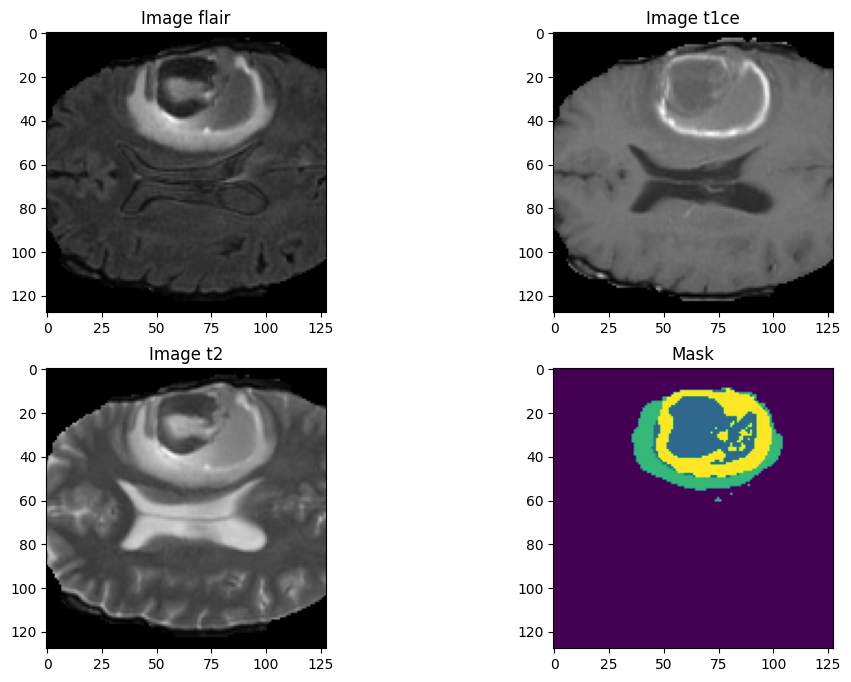

In [26]:
# A last check if the images makes sense
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_path + "/" + train_img_list[img_num])
test_mask = np.load(train_mask_path + "/" +train_mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [29]:
#pip install pandas

In [30]:
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list_temp = sorted(glob.glob('data_dir/trainval/train/masks/*.npy'))
for img in range(len(train_mask_list_temp)):
    #print(img)
    temp_image=np.load(train_mask_list_temp[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

print(f"Weight of label 0: {wt0}")
print(f"Weight of label 0: {wt1}")
print(f"Weight of label 0: {wt2}")
print(f"Weight of label 0: {wt3}")

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

Weight of label 0: 0.26
Weight of label 0: 22.53
Weight of label 0: 22.53
Weight of label 0: 26.21


<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-30-ae7ebae4259c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


In [31]:
wt0 = 0.26
wt1 = 22.53
wt2 = 22.53
wt3 = 26.21

In [75]:
# Make the generator avaiable
batch_size = 1

train_img_datagen = datagen.imageLoader(train_img_path, train_img_list, train_mask_path, train_mask_list,
                                       batch_size)

val_img_datagen = datagen.imageLoader(val_img_path, val_img_list, val_mask_path, val_mask_list,
                                       batch_size)

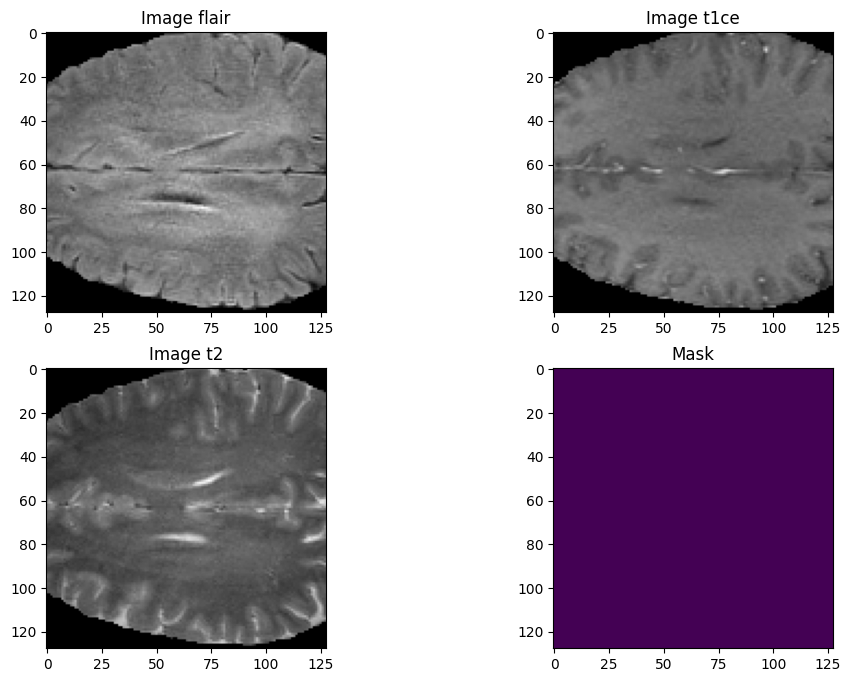

In [77]:
# Check that the generator works properly
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

### **Training the model**

In [78]:
import tensorflow as tf
import segmentation_models_3D as sm
#os.environ["KERAS_BACKEND"] = "tensorflow"

In [56]:
#pip install segmentation-models-3D

In [49]:
#pip install -U scikit-image

**Define loss, metrics and optimizer**

In [79]:
dice_loss = sm.losses.DiceLoss(class_weights = np.array([wt0,wt1,wt2,wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [80]:
metrics = ["accuracy", sm.metrics.IOUScore(threshold = 0.5)]
lr = 0.0001
optim = tf.keras.optimizers.Adam(lr)

In [81]:
train_steps = len(train_img_list) // batch_size
val_steps = len(val_img_list) // batch_size

In [82]:
from unet_basic import simple_unet_model

In [83]:
model = simple_unet_model(IMG_HEIGHT = 128,
                          IMG_WIDTH = 128,
                          IMG_DEPTH = 128,
                          IMG_CHANNELS = 3,
                          num_classes = 4)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_76 (Conv3D)             (None, 128, 128, 12  1312        ['input_5[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_36 (Dropout)           (None, 128, 128, 12  0           ['conv3d_76[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_88 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_17[0][0]']         
                                64)                                                               
                                                                                                  
 dropout_42 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_88[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_89 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_42[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

In [84]:
model.compile(optimizer = optim, loss = total_loss, metrics = metrics)

In [85]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [86]:
history = model.fit(train_img_datagen,
                   steps_per_epoch = train_steps,
                   validation_data = val_img_datagen,
                   validation_steps = val_steps,
                   epochs = 100, verbose = 1)

Epoch 1/100
258/258 [==============================] - 117s 434ms/step - loss: 0.0382 - accuracy: 0.7920 - iou_score: 0.2203 - val_loss: -1.6991 - val_accuracy: 0.8924 - val_iou_score: 0.2998
Epoch 2/100
258/258 [==============================] - 113s 439ms/step - loss: -2.2563 - accuracy: 0.8908 - iou_score: 0.3189 - val_loss: -2.9491 - val_accuracy: 0.9060 - val_iou_score: 0.3429
Epoch 3/100
258/258 [==============================] - 114s 441ms/step - loss: -3.6818 - accuracy: 0.9320 - iou_score: 0.3701 - val_loss: -3.7209 - val_accuracy: 0.9116 - val_iou_score: 0.3658
Epoch 4/100
258/258 [==============================] - 110s 427ms/step - loss: -4.7618 - accuracy: 0.9475 - iou_score: 0.4076 - val_loss: -5.2432 - val_accuracy: 0.9523 - val_iou_score: 0.4231
Epoch 5/100
258/258 [==============================] - 110s 426ms/step - loss: -5.8747 - accuracy: 0.9595 - iou_score: 0.4468 - val_loss: -5.9516 - val_accuracy: 0.9553 - val_iou_score: 0.4485
Epoch 6/100
258/258 [===============

258/258 [==============================] - 112s 435ms/step - loss: -12.4345 - accuracy: 0.9864 - iou_score: 0.7256 - val_loss: -10.3461 - val_accuracy: 0.9760 - val_iou_score: 0.6297
Epoch 44/100
258/258 [==============================] - 113s 436ms/step - loss: -12.3565 - accuracy: 0.9861 - iou_score: 0.7190 - val_loss: -10.7487 - val_accuracy: 0.9785 - val_iou_score: 0.6497
Epoch 45/100
258/258 [==============================] - 113s 437ms/step - loss: -12.4445 - accuracy: 0.9863 - iou_score: 0.7232 - val_loss: -10.7319 - val_accuracy: 0.9778 - val_iou_score: 0.6460
Epoch 46/100
258/258 [==============================] - 111s 431ms/step - loss: -12.6303 - accuracy: 0.9870 - iou_score: 0.7332 - val_loss: -10.7926 - val_accuracy: 0.9773 - val_iou_score: 0.6493
Epoch 47/100
258/258 [==============================] - 113s 437ms/step - loss: -12.4845 - accuracy: 0.9866 - iou_score: 0.7273 - val_loss: -10.2773 - val_accuracy: 0.9772 - val_iou_score: 0.6279
Epoch 48/100
258/258 [===========

Epoch 85/100
258/258 [==============================] - 109s 422ms/step - loss: -13.3599 - accuracy: 0.9899 - iou_score: 0.7757 - val_loss: -11.2209 - val_accuracy: 0.9823 - val_iou_score: 0.6708
Epoch 86/100
258/258 [==============================] - 111s 430ms/step - loss: -13.3348 - accuracy: 0.9898 - iou_score: 0.7719 - val_loss: -11.1106 - val_accuracy: 0.9819 - val_iou_score: 0.6641
Epoch 87/100
258/258 [==============================] - 111s 432ms/step - loss: -13.4017 - accuracy: 0.9899 - iou_score: 0.7745 - val_loss: -11.0751 - val_accuracy: 0.9802 - val_iou_score: 0.6610
Epoch 88/100
258/258 [==============================] - 111s 430ms/step - loss: -13.2378 - accuracy: 0.9888 - iou_score: 0.7663 - val_loss: -10.9591 - val_accuracy: 0.9799 - val_iou_score: 0.6586
Epoch 89/100
258/258 [==============================] - 109s 421ms/step - loss: -13.2079 - accuracy: 0.9889 - iou_score: 0.7648 - val_loss: -11.1610 - val_accuracy: 0.9818 - val_iou_score: 0.6683
Epoch 90/100
258/258

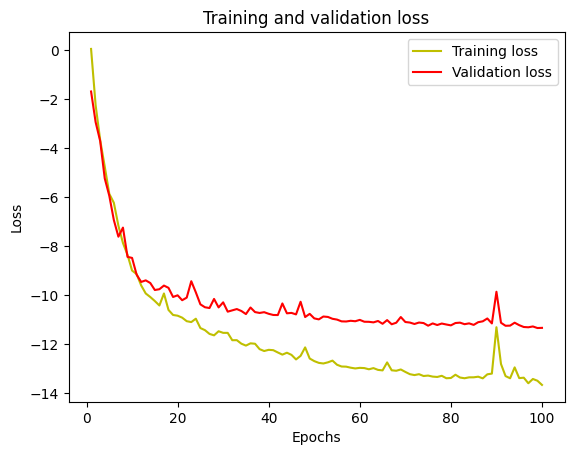

In [87]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

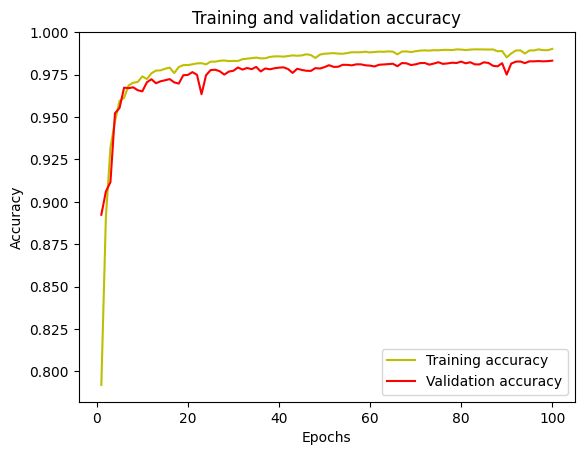

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [89]:
# Make a folder to store models
os.mkdir("models")
# Save the current model
model.save("models/brats_3d.hdf5")

In [114]:
from tensorflow.keras.models import load_model
# Import the model so that it can be trained further
modelV2 = load_model("models/brats_3d.hdf5", 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [118]:
#### TRAINING MORE DOESNT WORK ATM

#from tensorflow.keras.callbacks import LearningRateScheduler
# Make learning rate decay for further training
#lr = 5e-3
#n_epochs = 5
#def polynomial_decay(epoch):
#    """Function to allow for polynomial decay of the learning rate"""
#    maxEpochs = n_epochs
#    baseLR = lr
#    alpha = baseLR * (1 - (epoch / float(maxEpochs)))
#    return alpha

#callback = [LearningRateScheduler(polynomial_decay)]

In [119]:
#history2=modelV2.fit(train_img_datagen,
#                     steps_per_epoch = train_steps,
#                     validation_data = val_img_datagen,
#                     validation_steps = val_steps,
#                     epochs = n_epochs, verbose = 1,
#                     callbacks = callback)

**Evaluating performance**

In [120]:
batch_size = 4
test_img_datagen = datagen.imageLoader(val_img_path, 
                                       val_img_list, 
                                       val_mask_path, 
                                       val_mask_list,
                                       batch_size)

In [121]:
# Testing the new generator
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 4)

In [123]:
n_classes = 4
IoU_vals = tf.metrics.MeanIoU(num_classes=n_classes)
IoU_vals.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print(f"Mean IoU for one batch of test images {IoU_vals.result().numpy()}")

Mean IoU for one batch of test images 0.8234953880310059


**Predict for a brain volume**

In [147]:
# Select a random image to test
test_img_file = np.random.choice(val_img_list)
# Get the number corresponding to the selected image
test_img_num = filter(str.isdigit, test_img_file)
test_img_num = "".join(test_img_num)

# load that image
test_img = np.load(val_img_path + "/" + test_img_file)
test_mask = np.load(val_mask_path + "/mask_" + str(test_img_num) + ".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

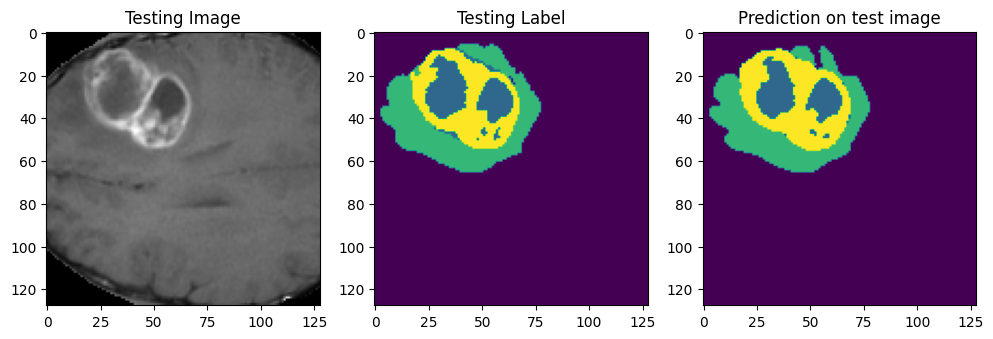

In [150]:
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 80
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [160]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_76 (Conv3D)             (None, 128, 128, 12  1312        ['input_5[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_36 (Dropout)           (None, 128, 128, 12  0           ['conv3d_76[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_88 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_17[0][0]']         
                                64)                                                               
                                                                                                  
 dropout_42 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_88[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_89 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_42[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr